# Note

In [1]:
!pip install dowhy
# pygraphviz install 
!apt install libgraphviz-dev
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.8 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 5 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,

In [2]:
import numpy as np
import pandas as pd
import os, sys
import dowhy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset 
- education 이 과연 미래의 소득 추정에도 영향을 끼쳤는지에 대한 분석입니다.
- 기존의 "ability" 변수는 개인의 능력으로 Confounder 로 작용합니다. 
- "education_voucher" 는 교육 쿠폰으로, Instrumental - varaible 로 작용합니다. 

In [3]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

# build dataset (exclude confounder `ability` which we assume to be unobserved)
data = np.stack([education, income, voucher]).T
df = pd.DataFrame(data, columns = ['education', 'income', 'voucher'])

In [4]:
df

,education,income,voucher
0,1.236292,2.902565,0.416822
1,8.473704,35.632684,2.722427
2,5.108380,26.201541,1.017628
3,8.555912,54.129423,0.595785
4,5.998117,26.409995,1.969233
...,...,...,...
995,12.616265,58.389432,3.401434
996,8.090951,42.793332,1.842875
997,8.454149,43.956082,2.016387
998,4.510123,22.821284,-0.376703


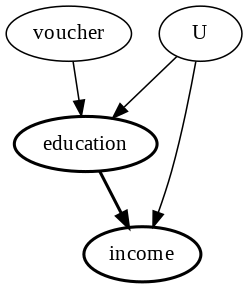

In [9]:
#Step 1: Modeling
# 이떄에 U 는 unobserved confounder 로 작용하게 됩니다. 
model=dowhy.CausalModel(
        data = df,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
# 크게 그리지 말자... 
model.view_model(size = (3,3))
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [8]:
# Step 2: Identify 를 실시합니다
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)
# 도구변수의 조건은 아래와 같다. 
# 1. Relevance : 도구변수는 원인변수에 충분히 영향을 주어야 함
# 2. Exclusion Restriction : 도구변수는 원인변수를 통해서가 아닌 다른 경로로 결과변수(유저 관여도)에 영향을 주지 않음
# 3. Exogenity : 도구변수와 결과변수에 둘다 영향을 주는 교란변수가 없음

# dowhy 에서는 as-if-random -> Exogenity 으로 이야기하고 있습니다.
# Relevance 는 딱히 체크하지 않는듯한데... 이는 좀 살펴봐야 할듯.
# F- Statistic 이 10 정도 이상이면 잘 쓸수 있다는 조건이 있는데 왜 안쓰는지 모르겠네? 

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(income, [voucher])*Derivative([education], [voucher])**
(-1))
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [23]:
# Step 3: Estimate
# 위에서 소개한 2번째 방법론을 사용하도록 하겠습니다. iv.instrumental_variable

estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable",
        test_significance=True)
print(estimate)

instrumental_variable
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(income, [voucher])*Derivative([education], [voucher])**
(-1))
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(income, voucher))⋅Expectation(Derivative(education, vou

      -1
cher))  
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['education'] is affected in the same way by commo

# 결과해석? 
- 위 결과에 따르면 Education 단위가 1 올라가면 그에 따라서 income 은 4 올라간다고 할 수 있다고 합니다. 
- 이제 Robustness check 를 해봅시다. 

In [11]:
# Step 4: Refute
ref = model.refute_estimate(identified_estimand,
                            estimate,
                            method_name="placebo_treatment_refuter",
                            placebo_type="permute") # only permute placebo_type works with IV estimate
print(ref)
# New effect 가 0 에 가까우므로, 우리의 추정이 robust 하다는것을 나타냅니다. 

Refute: Use a Placebo Treatment
Estimated effect:4.082517290550947
New effect:0.04724914946691824
p value:0.88



# IV2SLS 결과와 비교하기

In [34]:
df

,education,income,voucher
0,1.236292,2.902565,0.416822
1,8.473704,35.632684,2.722427
2,5.108380,26.201541,1.017628
3,8.555912,54.129423,0.595785
4,5.998117,26.409995,1.969233
...,...,...,...
995,12.616265,58.389432,3.401434
996,8.090951,42.793332,1.842875
997,8.454149,43.956082,2.016387
998,4.510123,22.821284,-0.376703


In [36]:
import patsy as ps
# sandbox model 이라 statmodels 는 사용안할려고...
# from statsmodels.sandbox.regression.gmm import IV2SLS

income_vec, endog =  ps.dmatrices("income ~ education", data=df)
exog = ps.dmatrix("voucher", data=df)

m = IV2SLS(df["income"], df["education"], instrument = df["voucher"]).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                 income   R-squared:                       0.991
Model:                         IV2SLS   Adj. R-squared:                  0.991
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Sun, 27 Nov 2022                                         
Time:                        16:51:44                                         
No. Observations:                1000                                         
Df Residuals:                     999                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
education      5.0339      0.017    300.282      0.000       5.001       5.067
==============================================================================
Omnibus:                        0.564   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.754   Jarque-Bera (JB):                0.650
Skew:                          -0.038   Prob(JB):                        0.723
Kurtosis:                       2.901   Cond. No.                         1.00
==============================================================================
"""

In [33]:
import patsy as ps
from statsmodels.sandbox.regression.gmm import IV2SLS

income_vec, endog =  ps.dmatrices("income ~ education", data=df)
exog = ps.dmatrix("voucher", data=df)

m = IV2SLS(income_vec, endog, exog).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                 income   R-squared:                       0.900
Model:                         IV2SLS   Adj. R-squared:                  0.900
Method:                     Two Stage   F-statistic:                     1477.
                        Least Squares   Prob (F-statistic):          4.84e-199
Date:                Sun, 27 Nov 2022                                         
Time:                        16:49:24                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5582      0.986      9.694      0.000       7.623      11.493
education      4.0825      0.106     38.432      0.000       3.874       4.291
==============================================================================
Omnibus:                        2.562   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.280
Skew:                           0.025   Prob(JB):                        0.320
Kurtosis:                       2.771   Cond. No.                         25.7
==============================================================================
"""